# Calculates QGPV gradients given mean velocity and buoyancy frequency profiles from cDrake

Profiles of mean geostrophic velocities from Cpies (they compare well with LADCP measurementes). From Teri:

"The basic structure is the same for LADCP and GEM-derived currents. See figure 12 in Yvonne Firing's JAOT paper for specifics.
http://dx.doi.org/10.1175/JTECH-D-13-00142.1 "

In [2]:
import numpy as np
from numpy import pi

import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
data = np.load('fields2stability.npz')

lat = -58
beta = 2*7.29e-5*cos(lat*pi/180.)/6371.e3 
i1 = 3
dec = 1
N2 = data['N2'][i1::dec]
U  = data['U'][i1::dec]
V  = data['V'][i1::dec]
z  = data['z'][i1::dec]
zp = (z[1:]+z[:-1])/2.


In [80]:
def calc_QyQx(N2,z,U,V,lat):

    """ Calculates QGPV gradients """

    f0 = 2*7.29e-5*sin(lat*pi/180.)
    beta = 2*7.29e-5*cos(lat*pi/180.)/6371.e3 
    S = f0**2 / N2

    nz = S.size
    dz = abs(z[1]-z[0])
    dz2 = dz**2

    #  assemble strecthing matrix (standard staggered grid second order FD)
    SM = np.zeros((nz-1,nz-1))
    for i in range(nz-1):
        if i == 0:
            SM[0,0], SM[0,1] = -S[1]-2*S[0],S[1]
        elif i==nz-2:
            SM[-1,-2], SM[-1,-1] = S[-2], -S[-2]-2*S[-1]
        else:
            SM[i,i-1], SM[i,i], SM[i,i+1] = S[i], -(S[i+1]+S[i]), S[i+1]
    
    SM = SM/dz2

    # recall staggered stencil in the interior
    Up = (U[:-1]+U[1:])/2.
    Vp = (V[:-1]+V[1:])/2.
    zp = (z[:-1]+z[1:])/2.

    # calculate the base state PV gradients
    LU = np.einsum('ij,j->i',SM,Up) 
    LV = np.einsum('ij,j->i',SM,Vp)

    # this solves for the ghost point (involves U[0], but solves U[1/2]...)
    LU[0]  += 2*S[0]*U[0]/dz2
    LU[-1] += 2*S[-1]*U[-1]/dz2
    LV[0]  += 2*S[0]*V[0]/dz2
    LV[-1] += 2*S[-1]*V[-1]/dz2

    Qx = LV
    Qy = (beta*0-LU)

    return Qx, Qy

In [81]:
Qx,Qy = calc_QyQx(N2,-z,U,V,lat=lat)

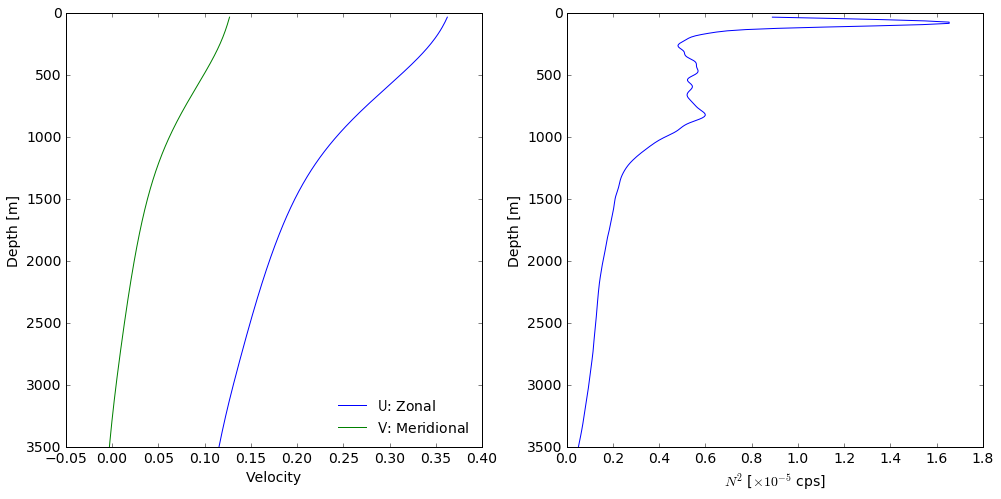

In [84]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(121)
ax1.plot(U,z,label=r'$\mathsf{U}$: Zonal')
ax1.plot(V,z,label=r'$\mathsf{V}$: Meridional')
ax1.set_ylim(3500,0)
ax1.set_xlabel('Velocity')
ax1.set_ylabel('Depth [m]')
ax1.legend(loc=4)


ax1 = fig.add_subplot(122)
ax1.plot(N2/1e-5,z)
ax1.set_ylim(3500,0)
ax1.set_xlabel(r'$N^2$ [$\times 10^{-5}$ cps]')
ax1.set_ylabel('Depth [m]')
ax1.legend(loc=4)

plt.tight_layout()


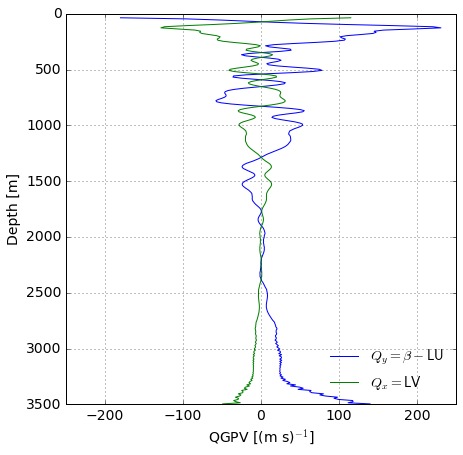

In [86]:
fig = plt.figure(figsize=(7,7))

ax1 = fig.add_subplot(111)


ax1.plot(Qy/beta,zp,label=r'$Q_y = \beta - \mathsf{L}\mathsf{U}$')
ax1.plot(Qx/beta,zp,label=r'$Q_x = \mathsf{L} \mathsf{V}$')
ax1.set_ylim(3500,0)
ax1.set_xlim(-250,250)
ax1.set_xlabel('QGPV [(m s)$^{-1}$]')
ax1.set_ylabel('Depth [m]')
ax1.legend(loc=4)
plt.grid()